# 1. Thư viện

In [7]:
 !pip install scikit-multilearn regex underthesea vncorenlp neattext pyvi wordcloud seaborn

  Using cached underthesea-6.8.4-py3-none-any.whl.metadata (15 kB)
  Using cached vncorenlp-1.0.3.tar.gz (2.6 MB)
  Preparing metadata (setup.py) ... done
  Using cached neattext-0.1.3-py3-none-any.whl.metadata (12 kB)
  Using cached pyvi-0.1.1-py2.py3-none-any.whl.metadata (2.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 66.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 84.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.5 MB/s eta 0:00:00
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645932 sha256=63b208d388c487155dacb5a29fdaf3abda82da2ecdd634d600d81b8d1f022f39
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp


In [9]:
import pandas as pd
import numpy as np
import spacy
from collections import Counter
from underthesea import word_tokenize, pos_tag
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

import underthesea
from underthesea import word_tokenize, text_normalize, pos_tag
import neattext as nt
from tqdm import tqdm
import regex as re 
tqdm.pandas()

import pandas as pd
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
from pyvi import ViTokenizer

In [10]:
data = pd.read_csv('/kaggle/input/dataclean/data_clean.csv')

In [11]:
data = data[['content', 'tags']]

In [12]:
# Tỷ lệ chia
train_size = 0.70
valid_size = 0.06
test_size = 0.24

# Kiểm tra tổng tỷ lệ
assert train_size + valid_size + test_size == 1.0, "Tổng tỷ lệ phải bằng 1.0"

In [13]:
# Chia dữ liệu thành train và temp (temp bao gồm valid và test)
train, temp = train_test_split(
    data,
    test_size=(valid_size + test_size),
    random_state=42,  # Đặt seed để đảm bảo tái lập kết quả
    shuffle=True  # Xáo trộn dữ liệu trước khi chia
)

# Tính tỷ lệ của valid và test trong temp
valid_ratio = valid_size / (valid_size + test_size)  # 0.06 / 0.30 = 0.2
test_ratio = test_size / (valid_size + test_size)    # 0.24 / 0.30 = 0.8

# Chia temp thành valid và test
valid, test = train_test_split(
    temp,
    test_size=test_ratio,
    random_state=42,
    shuffle=True
)

# Kiểm tra kích thước các tập
print(f"Train size: {len(train)}")
print(f"Validation size: {len(valid)}")
print(f"Test size: {len(test)}")

Train size: 67067
Validation size: 5748
Test size: 22996


In [14]:
# Lưu các tập dữ liệu thành CSV (tuỳ chọn)
train.to_csv('train.csv', index=False)
valid.to_csv('validation.csv', index=False)
test.to_csv('test.csv', index=False)

In [15]:
data

,content,tags
0,"Bước vào trận đấu, Barcelona nhanh chóng tràn ...","La Liga,Sevilla,Olimpic Lluis Companys,đè bẹp,..."
1,Willian đi vào lịch sử bóng đá xứ samba. Với 1...,"Estevao Willian,Neymar,giải VĐQG Brazil,Serie ..."
2,Mục tiêu lớn Phó Thủ tướng Chính phủ Lê Thành ...,"đăng cai,Đại hội Thể thao châu Á,ASIAD,thể dục..."
3,"Ngày 20-10, Giải bơi và lặn vô địch quốc gia n...","toàn đoàn,lặn,Vũ Đặng Nhật Nam,Nguyễn Lê Truyề..."
4,"Đồng chí Giàng Thị Dung, Phó Chủ tịch UBND tỉn...","Hồng Hà,Giàng Thị Dung,đua xe đạp,Lào Cai,LPBa..."
...,...,...
95806,Tạo động lực phát triển nhanh và bền vững của ...,"Kỳ họp,Quốc hội,tư duy,Trần Thanh Mẫn,nguồn lự..."
95807,"Theo số liệu của Tổng cục Hải quan, trong 9 th...","cao su tự nhiên,cao su,ANRPC,Chứng khoán MB,nư..."
95808,Mong có chiến lược ứng phó hiệu quả với thiên ...,"Kỳ họp thứ Tám,Trần Thanh Mẫn,ngắn gọn,Chủ tịc..."
95809,"Nhà chức trách xác định, Hoàng Văn Thảo có hàn...","Hoàng Văn Thảo,chạy án,Cục phó,giả danh,TP Hồ ..."


In [16]:
data['Content_Word_Count'] = data['content'].apply(lambda x: len(x.split()))
print(data[['content', 'Content_Word_Count']])

                                                 content  Content_Word_Count
0      Bước vào trận đấu, Barcelona nhanh chóng tràn ...                 217
1      Willian đi vào lịch sử bóng đá xứ samba. Với 1...                 314
2      Mục tiêu lớn Phó Thủ tướng Chính phủ Lê Thành ...                 903
3      Ngày 20-10, Giải bơi và lặn vô địch quốc gia n...                 364
4      Đồng chí Giàng Thị Dung, Phó Chủ tịch UBND tỉn...                 997
...                                                  ...                 ...
95806  Tạo động lực phát triển nhanh và bền vững của ...                1136
95807  Theo số liệu của Tổng cục Hải quan, trong 9 th...                 647
95808  Mong có chiến lược ứng phó hiệu quả với thiên ...                1360
95809  Nhà chức trách xác định, Hoàng Văn Thảo có hàn...                 353
95810  Trong 6 tháng đầu năm 2024, Sở Y tế thành phố ...                 689

[95811 rows x 2 columns]


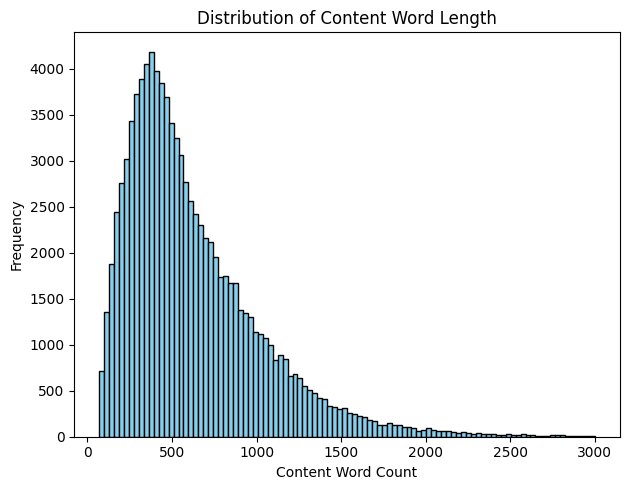

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(data['Content_Word_Count'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Content Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Content Word Length')

plt.tight_layout()
plt.show()

In [18]:
data1 = data[(data['Content_Word_Count'] <= 800)] # | (data['tags_length'] > 21)]
data1.shape

(70680, 3)

In [19]:
70680/95811

0.7377023515045246

* ** Nếu sử dụng Mô hình có max_token_length=1024 sẽ kiểm soát được 85% độ dài theo token của Content **
  * ** Nếu sử dụng Mô hình có max_token_length=800 sẽ kiểm soát được 73% độ dài theo token của Content **
* ** Còn nếu sử dụng Mô hình có max_token_length=512 sẽ chỉ kiểm soát được 49% độ dài theo token của Content **

In [20]:
stopwords = [
    "a lô", "a ha", "ai", "ai ai", "ai nấy", "ai đó", "alô", "amen",
    "anh", "anh ấy", "ba", "ba ba", "ba bản", "ba cùng", "ba họ", "ba ngày",
    "ba ngôi", "ba tăng", "bao giờ", "bao lâu", "bao nhiêu", "bao nả",
    "bay biến", "biết", "biết bao", "biết bao nhiêu", "biết chắc",
    "biết chừng nào", "biết mình", "biết mấy", "biết thế", "biết trước",
    "biết việc", "biết đâu", "biết đâu chừng", "biết đâu đấy",
    "biết được", "buổi", "buổi làm", "buổi mới", "buổi ngày", "buổi sớm",
    "bà", "bà ấy", "bài", "bài bác", "bài bỏ", "bài cái", "bác", "bán",
    "bán cấp", "bán dạ", "bán thế", "bây bẩy", "bây chừ", "bây giờ",
    "bây nhiêu", "bèn", "béng", "bên", "bên bị", "bên có", "bên cạnh",
    "bông", "bước", "bước khỏi", "bước tới", "bước đi", "bạn", "bản",
    "bản bộ", "bản riêng", "bản thân", "bản ý", "bất chợt", "bất cứ",
    "bất giác", "bất kì", "bất kể", "bất kỳ", "bất luận", "bất ngờ",
    "bất nhược", "bất quá", "bất quá chỉ", "bất thình lình", "bất tử",
    "bất đồ", "bấy", "bấy chầy", "bấy chừ", "bấy giờ", "bấy lâu",
    "bấy lâu nay", "bấy nay", "bấy nhiêu", "bập bà bập bõm", "bập bõm",
    "bắt đầu", "bắt đầu từ", "bằng", "bằng cứ", "bằng không", "bằng người",
    "bằng nhau", "bằng như", "bằng nào", "bằng nấy", "bằng vào",
    "bằng được", "bằng ấy", "bển", "bệt", "bị", "bị chú", "bị vì",
    "bỏ", "bỏ bà", "bỏ cha", "bỏ cuộc", "bỏ không", "bỏ lại",
    "bỏ mình", "bỏ mất", "bỏ mẹ", "bỏ nhỏ", "bỏ quá", "bỏ ra",
    "bỏ riêng", "bỏ việc", "bỏ xa", "bỗng", "bỗng chốc", "bỗng dưng",
    "bỗng không", "bỗng nhiên", "bỗng nhưng", "bỗng thấy", "bỗng đâu",
    "bộ", "bộ thuộc", "bộ điều", "bội phần", "bớ", "bởi", "bởi ai",
    "bởi chưng", "bởi nhưng", "bởi sao", "bởi thế", "bởi thế cho nên",
    "bởi tại", "bởi vì", "bởi vậy", "bởi đâu", "bức", "cao", "cao lâu",
    "cao ráo", "cao răng", "cao sang", "cao số", "cao thấp", "cao thế",
    "cao xa", "cha", "cha chả", "chao ôi", "chia sẻ", "chiếc", "cho",
    "cho biết", "cho chắc", "cho hay", "cho nhau", "cho nên", "cho rằng",
    "cho rồi", "cho thấy", "cho tin", "cho tới", "cho tới khi", "cho về",
    "cho ăn", "cho đang", "cho được", "cho đến", "cho đến khi", "cho đến nỗi",
    "choa", "chu cha", "chui cha", "chung", "chung cho", "chung chung",
    "chung cuộc", "chung cục", "chung nhau", "chung qui", "chung quy",
    "chung quy lại", "chung ái", "chuyển", "chuyển tự", "chuyển đạt",
    "chuyện", "chuẩn bị", "chành chạnh", "chí chết", "chính", "chính bản",
    "chính giữa", "chính là", "chính thị", "chính điểm", "chùn chùn",
    "chùn chũn", "chú", "chú dẫn", "chú khách", "chú mày", "chú mình",
    "chúng", "chúng mình", "chúng ta", "chúng tôi", "chúng ông",
    "chăn chắn", "chăng", "chăng chắc", "chăng nữa", "chơi", "chơi họ",
    "chưa", "chưa bao giờ", "chưa chắc", "chưa có", "chưa cần",
    "chưa dùng", "chưa dễ", "chưa kể", "chưa tính", "chưa từng",
    "chầm chập", "chậc", "chắc", "chắc chắn", "chắc dạ", "chắc hẳn",
    "chắc lòng", "chắc người", "chắc vào", "chắc ăn", "chẳng lẽ",
    "chẳng những", "chẳng nữa", "chẳng phải", "chết nỗi", "chết thật",
    "chết tiệt", "chỉ", "chỉ chính", "chỉ có", "chỉ là", "chỉ tên",
    "chỉn", "chị", "chị bộ", "chị ấy", "chịu", "chịu chưa", "chịu lời",
    "chịu tốt", "chịu ăn", "chọn", "chọn bên", "chọn ra", "chốc chốc",
    "chớ", "chớ chi", "chớ gì", "chớ không", "chớ kể", "chớ như",
    "chợt", "chợt nghe", "chợt nhìn", "chủn", "chứ", "chứ ai",
    "chứ còn", "chứ gì", "chứ không", "chứ không phải", "chứ lại",
    "chứ lị", "chứ như", "chứ sao", "coi bộ", "coi mòi", "con",
    "con con", "con dạ", "con nhà", "con tính", "cu cậu", "cuối",
    "cuối cùng", "cuối điểm", "cuốn", "cuộc", "càng", "càng càng",
    "càng hay", "cá nhân", "các", "các cậu", "cách", "cách bức",
    "cách không", "cách nhau", "cách đều", "cái", "cái gì", "cái họ",
    "cái đã", "cái đó", "cái ấy", "câu hỏi", "cây", "cây nước",
    "còn", "còn như", "còn nữa", "còn thời gian", "còn về",
    "có", "có ai", "có chuyện", "có chăng", "có chăng là",
    "có chứ", "có cơ", "có dễ", "có họ", "có khi", "có ngày",
    "có người", "có nhiều", "có nhà", "có phải", "có số", "có tháng",
    "có thế", "có thể", "có vẻ", "có ý", "có ăn", "có điều",
    "có điều kiện", "có đáng", "có đâu", "có được", "cóc khô",
    "cô", "cô mình", "cô quả", "cô tăng", "cô ấy", "công nhiên",
    "cùng", "cùng chung", "cùng cực", "cùng nhau", "cùng tuổi",
    "cùng tột", "cùng với", "cùng ăn", "căn", "căn cái", "căn cắt",
    "căn tính", "cũng", "cũng như", "cũng nên", "cũng thế",
    "cũng vậy", "cũng vậy thôi", "cũng được", "cơ", "cơ chỉ",
    "cơ chừng", "cơ cùng", "cơ dẫn", "cơ hồ", "cơ hội", "cơ mà",
    "cơn", "cả", "cả nghe", "cả nghĩ", "cả ngày", "cả người",
    "cả nhà", "cả năm", "cả thảy", "cả thể", "cả tin", "cả ăn",
    "cả đến", "cảm thấy", "cảm ơn", "cấp", "cấp số", "cấp trực tiếp",
    "cần", "cần cấp", "cần gì", "cần số", "cật lực", "cật sức",
    "cậu", "cổ lai", "cụ thể", "cụ thể là", "cụ thể như", "của",
    "của ngọt", "của tin", "cứ", "cứ như", "cứ việc", "cứ điểm",
    "cực lực", "do", "do vì", "do vậy", "do đó", "duy", "duy chỉ",
    "duy có", "dài", "dài lời", "dài ra", "dành", "dành dành",
    "dào", "dì", "dù", "dù cho", "dù dì", "dù gì", "dù rằng",
    "dù sao", "dùng", "dùng cho", "dùng hết", "dùng làm", "dùng đến",
    "dưới", "dưới nước", "dạ", "dạ bán", "dạ con", "dạ dài",
    "dạ dạ", "dạ khách", "dần dà", "dần dần", "dầu sao",
    "dẫn", "dẫu", "dẫu mà", "dẫu rằng", "dẫu sao", "dễ",
    "dễ dùng", "dễ gì", "dễ khiến", "dễ nghe", "dễ ngươi",
    "dễ như chơi", "dễ sợ", "dễ sử dụng", "dễ thường",
    "dễ thấy", "dễ ăn", "dễ đâu", "dở chừng", "dữ", "dữ cách",
    "em", "em em", "giá trị", "giá trị thực tế", "giảm",
    "giảm chính", "giảm thấp", "giảm thế", "giống", "giống người",
    "giống nhau", "giống như", "giờ", "giờ lâu", "giờ này",
    "giờ đi", "giờ đây", "giờ đến", "giữ", "giữ lấy", "giữ ý",
    "giữa", "giữa lúc", "gây", "gây cho", "gây giống", "gây ra",
    "gây thêm", "gì", "gì gì", "gì đó", "gần", "gần bên", "gần hết",
    "gần ngày", "gần như", "gần xa", "gần đây", "gần đến", "gặp",
    "gặp khó khăn", "gặp phải", "gồm", "hay", "hay biết", "hay hay",
    "hay không", "hay là", "hay làm", "hay nhỉ", "hay nói",
    "hay sao", "hay tin", "hay đâu", "hiểu", "hiện nay", "hiện tại",
    "hoàn toàn", "hoặc", "hoặc là", "hãy", "hãy còn", "hơn",
    "hơn cả", "hơn hết", "hơn là", "hơn nữa", "hơn trước",
    "hầu hết", "hết", "hết chuyện", "hết cả", "hết của",
    "hết nói", "hết ráo", "hết rồi", "hết ý", "họ", "họ gần",
    "họ xa", "hỏi", "hỏi lại", "hỏi xem", "hỏi xin", "hỗ trợ",
    "khi", "khi khác", "khi không", "khi nào", "khi nên",
    "khi trước", "khiến", "khoảng", "khoảng cách", "khoảng không",
    "khá", "khá tốt", "khác", "khác gì", "khác khác", "khác nhau",
    "khác nào", "khác thường", "khác xa", "khách", "khó",
    "khó biết", "khó chơi", "khó khăn", "khó làm", "khó mở",
    "khó nghe", "khó nghĩ", "khó nói", "khó thấy", "khó tránh",
    "không", "không ai", "không bao giờ", "không bao lâu",
    "không biết", "không bán", "không chỉ", "không còn", "không có",
    "không có gì", "không cùng", "không cần", "không cứ", "không dùng",
    "không gì", "không hay", "không khỏi", "không kể",
    "không ngoài", "không nhận", "không những", "không phải",
    "không phải không", "không thể", "không tính",
    "không điều kiện", "không được", "không đầy", "không để",
    "khẳng định", "khỏi", "khỏi nói", "kể", "kể cả", "kể như",
    "kể tới", "kể từ", "liên quan", "loại", "loại từ", "luôn",
    "luôn cả", "luôn luôn", "luôn tay", "là", "là cùng", "là là",
    "là nhiều", "là phải", "là thế nào", "là vì", "là ít",
    "làm", "làm bằng", "làm cho", "làm dần dần", "làm gì",
    "làm lòng", "làm lại", "làm lấy", "làm mất", "làm ngay",
    "làm như", "làm nên", "làm ra", "làm riêng", "làm sao",
    "làm theo", "làm thế nào", "làm tin", "làm tôi", "làm tăng",
    "làm tại", "làm tắp lự", "làm vì", "làm đúng", "làm được",
    "lâu", "lâu các", "lâu lâu", "lâu nay", "lâu ngày", "lên",
    "lên cao", "lên cơn", "lên mạnh", "lên ngôi", "lên nước",
    "lên số", "lên xuống", "lên đến", "lòng", "lòng không",
    "lúc", "lúc khác", "lúc lâu", "lúc nào", "lúc này",
    "lúc sáng", "lúc trước", "lúc đi", "lúc đó", "lúc đến",
    "lúc ấy", "lý do", "lượng", "lượng cả", "lượng số", "lượng từ",
    "lại", "lại bộ", "lại cái", "lại còn", "lại giống", "lại làm",
    "lại người", "lại nói", "lại nữa", "lại quả", "lại thôi",
    "lại ăn", "lại đây", "lấy", "lấy có", "lấy cả", "lấy giống",
    "lấy làm", "lấy lý do", "lấy lại", "lấy ra", "lấy ráo",
    "lấy sau", "lấy số", "lấy thêm", "lấy thế", "lấy vào",
    "lấy xuống", "lấy được", "lấy để", "lần", "lần khác",
    "lần lần", "lần nào", "lần này", "lần sang", "lần sau",
    "lần theo", "lần trước", "lần tìm", "lớn", "lớn lên", "lớn nhỏ",
    "lời", "lời chú", "lời nói", "mang", "mang lại", "mang mang",
    "mang nặng", "mang về", "muốn", "mà", "mà cả", "mà không",
    "mà lại", "mà thôi", "mà vẫn", "mình", "mạnh", "mất",
    "mất còn", "mọi", "mọi giờ", "mọi khi", "mọi lúc", "mọi người",
    "mọi nơi", "mọi sự", "mọi thứ", "mọi việc", "mối", "mỗi",
    "mỗi lúc", "mỗi lần", "mỗi một", "mỗi ngày", "mỗi người",
    "một", "một cách", "một cơn", "một khi", "một lúc",
    "một số", "một vài", "một ít", "mới", "mới hay", "mới rồi",
    "mới đây", "mở", "mở mang", "mở nước", "mở ra", "mợ", "mức",
    "nay", "ngay", "ngay bây giờ", "ngay cả", "ngay khi",
    "ngay khi đến", "ngay lúc", "ngay lúc này", "ngay lập tức",
    "ngay thật", "ngay tức khắc", "ngay tức thì", "ngay từ",
    "nghe", "nghe chừng", "nghe hiểu", "nghe không", "nghe lại",
    "nghe nhìn", "nghe như", "nghe nói", "nghe ra", "nghe rõ",
    "nghe thấy", "nghe tin", "nghe trực tiếp", "nghe đâu",
    "nghe đâu như", "nghe được", "nghen", "nghiễm nhiên", "nghĩ",
    "nghĩ lại", "nghĩ ra", "nghĩ tới", "nghĩ xa", "nghĩ đến",
    "nghìm", "ngoài", "ngoài này", "ngoài ra", "ngoài xa", "ngoải",
    "nguồn", "ngày", "ngày càng", "ngày cấp", "ngày giờ",
    "ngày ngày", "ngày nào", "ngày này", "ngày nọ", "ngày qua",
    "ngày rày", "ngày tháng", "ngày xưa", "ngày xửa", "ngày đến",
    "ngày ấy", "ngôi", "ngôi nhà", "ngôi thứ", "ngõ hầu",
    "ngăn ngắt", "ngươi", "người", "người hỏi", "người khác",
    "người khách", "người mình", "người nghe", "người người",
    "người nhận", "ngọn", "ngọn nguồn", "ngọt", "ngồi",
    "ngồi bệt", "ngồi không", "ngồi sau", "ngồi trệt", "ngộ nhỡ",
    "nhanh", "nhanh lên", "nhanh tay", "nhau", "nhiên hậu",
    "nhiều", "nhiều ít", "nhiệt liệt", "nhung nhăng", "nhà",
    "nhà chung", "nhà khó", "nhà làm", "nhà ngoài", "nhà ngươi",
    "nhà tôi", "nhà việc", "nhân dịp", "nhân tiện", "nhé",
    "nhìn", "nhìn chung", "nhìn lại", "nhìn nhận", "nhìn theo",
    "nhìn thấy", "nhìn xuống", "nhóm", "nhón nhén", "như",
    "như ai", "như chơi", "như không", "như là", "như nhau",
    "như quả", "như sau", "như thường", "như thế", "như thế nào",
    "như thể", "như trên", "như trước", "như tuồng", "như vậy",
    "như ý", "nhưng", "nhưng mà", "nhược bằng", "nhất",
    "nhất loạt", "nhất luật", "nhất là", "nhất mực", "nhất nhất",
    "nhất quyết", "nhất sinh", "nhất thiết", "nhất thì",
    "nhất tâm", "nhất tề", "nhất đán", "nhất định", "nhận",
    "nhận biết", "nhận họ", "nhận làm", "nhận nhau", "nhận ra",
    "nhận thấy", "nhận việc", "nhận được", "nhằm", "nhằm khi",
    "nhằm lúc", "nhằm vào", "nhằm để", "nhỉ", "nhỏ",
    "nhỏ người", "nhớ", "nhớ bập bõm", "nhớ lại", "nhớ lấy",
    "nhớ ra", "nhờ", "nhờ chuyển", "nhờ có", "nhờ nhờ",
    "nhờ đó", "nhỡ ra", "những", "những ai", "những khi",
    "những là", "những lúc", "những muốn", "những như", "nào",
    "nào cũng", "nào hay", "nào là", "nào phải", "nào đâu",
    "nào đó", "này", "này nọ", "nên", "nên chi", "nên chăng",
    "nên làm", "nên người", "nên tránh", "nó", "nóc", "nói",
    "nói bông", "nói chung", "nói khó", "nói là", "nói lên",
    "nói lại", "nói nhỏ", "nói phải", "nói qua", "nói ra",
    "nói riêng", "nói rõ", "nói thêm", "nói thật", "nói toẹt",
    "nói trước", "nói tốt", "nói với", "nói xa", "nói ý",
    "nói đến", "nói đủ", "năm", "năm tháng", "nơi", "nơi nơi",
    "nước", "nước bài", "nước cùng", "nước lên", "nước nặng",
    "nước quả", "nước xuống", "nước ăn", "nước đến", "nấy",
    "nặng", "nặng căn", "nặng mình", "nặng về", "nếu", "nếu có",
    "nếu cần", "nếu không", "nếu mà", "nếu như", "nếu thế",
    "nếu vậy", "nếu được", "nền", "nọ", "nớ", "nức nở", "nữa",
    "nữa khi", "nữa là", "nữa rồi", "oai oái", "oái", "pho",
    "phè", "phè phè", "phía", "phía bên", "phía bạn", "phía dưới",
    "phía sau", "phía trong", "phía trên", "phía trước", "phóc",
    "phót", "phù hợp", "phăn phắt", "phương chi", "phải",
    "phải biết", "phải chi", "phải chăng", "phải cách",
    "phải cái", "phải giờ", "phải khi", "phải không",
    "phải lại", "phải lời", "phải người", "phải như", "phải rồi",
    "phải tay", "phần", "phần lớn", "phần nhiều", "phần nào",
    "phần sau", "phần việc", "phắt", "phỉ phui", "phỏng",
    "phỏng như", "phỏng nước", "phỏng theo", "phỏng tính",
    "phốc", "phụt", "phứt", "qua", "qua chuyện", "qua khỏi",
    "qua lại", "qua lần", "qua ngày", "qua tay", "qua thì",
    "qua đi", "quan trọng", "quan trọng vấn đề", "quan tâm",
    "quay", "quay bước", "quay lại", "quay số", "quay đi",
    "quá", "quá bán", "quá bộ", "quá giờ", "quá lời",
    "quá mức", "quá nhiều", "quá tay", "quá thì", "quá tin",
    "quá trình", "quá tuổi", "quá đáng", "quá ư", "quả",
    "quả là", "quả thật", "quả thế", "quả vậy", "quận", "ra",
    "ra bài", "ra bộ", "ra chơi", "ra gì", "ra lại", "ra lời",
    "ra ngôi", "ra người", "ra sao", "ra tay", "ra vào", "ra ý",
    "ra điều", "ra đây", "ren rén", "riu ríu", "riêng",
    "riêng từng", "riệt", "rày", "ráo", "ráo cả", "ráo nước",
    "ráo trọi", "rén", "rén bước", "rích", "rón rén", "rõ",
    "rõ là", "rõ thật", "rút cục", "răng", "răng răng", "rất",
    "rất lâu", "rằng", "rằng là", "rốt cuộc", "rốt cục", "rồi",
    "rồi nữa", "rồi ra", "rồi sao", "rồi sau", "rồi tay",
    "rồi thì", "rồi xem", "rồi đây", "rứa", "sa sả", "sang",
    "sang năm", "sang sáng", "sang tay", "sao", "sao bản",
    "sao bằng", "sao cho", "sao vậy", "sao đang", "sau",
    "sau chót", "sau cuối", "sau cùng", "sau hết", "sau này",
    "sau nữa", "sau sau", "sau đây", "sau đó", "so",
    "so với", "song le", "suýt", "suýt nữa", "sáng",
    "sáng ngày", "sáng rõ", "sáng thế", "sáng ý", "sì",
    "sì sì", "sất", "sắp", "sắp đặt", "sẽ", "sẽ biết",
    "sẽ hay", "số", "số cho biết", "số cụ thể", "số loại",
    "số là", "số người", "số phần", "số thiếu", "sốt sột",
    "sớm", "sớm ngày", "sở dĩ", "sử dụng", "sự", "sự thế",
    "sự việc", "tanh", "tanh tanh", "tay", "tay quay",
    "tha hồ", "tha hồ chơi", "tha hồ ăn", "than ôi", "thanh",
    "thanh ba", "thanh chuyển", "thanh không", "thanh thanh",
    "thanh tính", "thanh điều kiện", "thanh điểm", "thay đổi",
    "thay đổi tình trạng", "theo", "theo bước", "theo như",
    "theo tin", "thi thoảng", "thiếu", "thiếu gì", "thiếu điểm",
    "thoạt", "thoạt nghe", "thoạt nhiên", "thoắt", "thuần",
    "thuần ái", "thuộc", "thuộc bài", "thuộc cách", "thuộc lại",
    "thuộc từ", "thà", "thà là", "thà rằng", "thành ra",
    "thành thử", "thái quá", "tháng", "tháng ngày",
    "tháng năm", "tháng tháng", "thêm", "thêm chuyện", "thêm giờ",
    "thêm vào", "thì", "thì giờ", "thì là", "thì phải",
    "thì ra", "thì thôi", "thình lình", "thích", "thích cứ",
    "thích thuộc", "thích tự", "thích ý", "thím", "thôi",
    "thôi việc", "thúng thắng", "thương ôi", "thường",
    "thường bị", "thường hay", "thường khi", "thường số",
    "thường sự", "thường thôi", "thường thường",
    "thường tính", "thường tại", "thường xuất hiện",
    "thường đến", "thảo hèn", "thảo nào", "thấp", "thấp cơ",
    "thấp thỏm", "thấp xuống", "thấy", "thấy tháng", "thẩy",
    "thậm", "thậm chí", "thậm cấp", "thậm từ", "thật",
    "thật chắc", "thật là", "thật lực", "thật quả", "thật ra",
    "thật sự", "thật thà", "thật tốt", "thật vậy", "thế",
    "thế chuẩn bị", "thế là", "thế lại", "thế mà", "thế nào",
    "thế nên", "thế ra", "thế sự", "thế thì", "thế thôi",
    "thế thường", "thế thế", "thế à", "thế đó", "thếch",
    "thỉnh thoảng", "thỏm", "thốc", "thốc tháo", "thốt",
    "thốt nhiên", "thốt nói", "thốt thôi", "thộc",
    "thời gian", "thời gian sử dụng", "thời gian tính",
    "thời điểm", "thục mạng", "thứ", "thứ bản", "thứ đến",
    "thửa", "thực hiện", "thực hiện đúng", "thực ra",
    "thực sự", "thực tế", "thực vậy", "tin", "tin thêm",
    "tin vào", "tiếp theo", "tiếp tục", "tiếp đó", "tiện thể",
    "toà", "toé khói", "toẹt", "trong", "trong khi",
    "trong lúc", "trong mình", "trong ngoài", "trong này",
    "trong số", "trong vùng", "trong đó", "trong ấy", "tránh",
    "tránh khỏi", "tránh ra", "tránh tình trạng", "tránh xa",
    "trên", "trên bộ", "trên dưới", "trước", "trước hết",
    "trước khi", "trước kia", "trước nay", "trước ngày",
    "trước nhất", "trước sau", "trước tiên", "trước tuổi",
    "trước đây", "trước đó", "trả", "trả của", "trả lại",
    "trả ngay", "trả trước", "trếu tráo", "trển", "trệt",
    "trệu trạo", "trỏng", "trời đất ơi", "trở thành",
    "trừ phi", "trực tiếp", "trực tiếp làm", "tuy", "tuy có",
    "tuy là", "tuy nhiên", "tuy rằng", "tuy thế", "tuy vậy",
    "tuy đã", "tuyệt nhiên", "tuần tự", "tuốt luốt",
    "tuốt tuồn tuột", "tuốt tuột", "tuổi", "tuổi cả",
    "tuổi tôi", "tà tà", "tên", "tên chính", "tên cái",
    "tên họ", "tên tự", "tênh", "tênh tênh", "tìm",
    "tìm bạn", "tìm cách", "tìm hiểu", "tìm ra", "tìm việc",
    "tình trạng", "tính", "tính cách", "tính căn", "tính người",
    "tính phỏng", "tính từ", "tít mù", "tò te", "tôi",
    "tôi con", "tông tốc", "tù tì", "tăm tắp", "tăng",
    "tăng chúng", "tăng cấp", "tăng giảm", "tăng thêm",
    "tăng thế", "tại", "tại lòng", "tại nơi", "tại sao",
    "tại tôi", "tại vì", "tại đâu", "tại đây", "tại đó",
    "tạo", "tạo cơ hội", "tạo nên", "tạo ra", "tạo ý",
    "tạo điều kiện", "tấm", "tấm bản", "tấm các", "tấn",
    "tấn tới", "tất cả", "tất cả bao nhiêu", "tất thảy",
    "tất tần tật", "tất tật", "tập trung", "tắp",
    "tắp lự", "tắp tắp", "tọt", "tỏ ra", "tỏ vẻ", "tốc tả",
    "tối ư", "tốt", "tốt bạn", "tốt bộ", "tốt hơn",
    "tốt mối", "tốt ngày", "tột", "tột cùng", "tớ", "tới",
    "tới gần", "tới mức", "tới nơi", "tới thì", "tức thì",
    "tức tốc", "từ", "từ căn", "từ giờ", "từ khi",
    "từ loại", "từ nay", "từ thế", "từ tính", "từ tại",
    "từ từ", "từ ái", "từ điều", "từ đó", "từ ấy", "từng",
    "từng cái", "từng giờ", "từng nhà", "từng phần",
    "từng thời gian", "từng đơn vị", "từng ấy", "tự",
    "tự cao", "tự khi", "tự lượng", "tự tính", "tự tạo",
    "tự vì", "tự ý", "tự ăn", "tựu trung", "veo",
    "veo veo", "việc", "việc gì", "vung thiên địa",
    "vung tàn tán", "vung tán tàn", "và", "vài", "vài ba",
    "vài người", "vài nhà", "vài nơi", "vài tên", "vài điều",
    "vào", "vào gặp", "vào khoảng", "vào lúc", "vào vùng",
    "vào đến", "vâng", "vâng chịu", "vâng dạ", "vâng vâng",
    "vâng ý", "vèo", "vèo vèo", "vì", "vì chưng", "vì rằng",
    "vì sao", "vì thế", "vì vậy", "ví bằng", "ví dù",
    "ví phỏng", "ví thử", "vô hình trung", "vô kể",
    "vô luận", "vô vàn", "vùng", "vùng lên", "vùng nước",
    "văng tê", "vượt", "vượt khỏi", "vượt quá", "vạn nhất",
    "vả chăng", "vả lại", "vấn đề", "vấn đề quan trọng",
    "vẫn", "vẫn thế", "vậy", "vậy là", "vậy mà",
    "vậy nào", "vậy nên", "vậy ra", "vậy thì", "vậy ư",
    "về", "về không", "về nước", "về phần", "về sau",
    "về tay", "vị trí", "vị tất", "vốn dĩ", "với",
    "với lại", "với nhau", "vở", "vụt", "vừa", "vừa khi",
    "vừa lúc", "vừa mới", "vừa qua", "vừa rồi", "vừa vừa",
    "xa", "xa cách", "xa gần", "xa nhà", "xa tanh",
    "xa tắp", "xa xa", "xa xả", "xem", "xem lại", "xem ra",
    "xem số", "xin", "xin gặp", "xin vâng", "xiết bao",
    "xon xón", "xoành xoạch", "xoét", "xoẳn", "xoẹt",
    "xuất hiện", "xuất kì bất ý", "xuất kỳ bất ý", "xuể",
    "xuống", "xăm xúi", "xăm xăm", "xăm xắm", "xảy ra",
    "xềnh xệch", "xệp", "xử lý", "yêu cầu", "à", "à này",
    "à ơi", "ào", "ào vào", "ào ào", "á", "á à", "ái",
    "ái chà", "ái dà", "áng", "áng như", "âu là", "ít",
    "ít biết", "ít có", "ít hơn", "ít khi", "ít lâu",
    "ít nhiều", "ít nhất", "ít nữa", "ít quá", "ít ra",
    "ít thôi", "ít thấy", "ô hay", "ô hô", "ô kê", "ô kìa",
    "ôi chao", "ôi thôi", "ông", "ông nhỏ", "ông tạo",
    "ông từ", "ông ấy", "ông ổng", "úi", "úi chà", "úi dào",
    "ý", "ý chừng", "ý da", "ý hoặc", "ăn", "ăn chung",
    "ăn chắc", "ăn chịu", "ăn cuộc", "ăn hết", "ăn hỏi",
    "ăn làm", "ăn người", "ăn ngồi", "ăn quá", "ăn riêng",
    "ăn sáng", "ăn tay", "ăn trên", "ăn về", "đang",
    "đang tay", "đang thì", "điều", "điều gì", "điều kiện",
    "điểm", "điểm chính", "điểm gặp", "điểm đầu tiên",
    "đành đạch", "đáng", "đáng kể", "đáng lí", "đáng lý",
    "đáng lẽ", "đáng số", "đánh giá", "đánh đùng", "đáo để",
    "đâu", "đâu có", "đâu cũng", "đâu như", "đâu nào",
    "đâu phải", "đâu đâu", "đâu đây", "đâu đó", "đây",
    "đây này", "đây rồi", "đây đó", "đã", "đã hay",
    "đã không", "đã là", "đã lâu", "đã thế", "đã vậy",
    "đã đủ", "đó", "đó đây", "đúng", "đúng ngày",
    "đúng ra", "đúng tuổi", "đúng với", "đơn vị", "đưa",
    "đưa cho", "đưa chuyện", "đưa em", "đưa ra", "đưa tay",
    "đưa tin", "đưa tới", "đưa vào", "đưa về", "đưa xuống",
    "đưa đến", "được", "được cái", "được lời", "được nước",
    "được tin", "đại loại", "đại nhân", "đại phàm", "đại để",
    "đạt", "đảm bảo", "đầu tiên", "đầy", "đầy năm",
    "đầy phè", "đầy tuổi", "đặc biệt", "đặt", "đặt làm",
    "đặt mình", "đặt mức", "đặt ra", "đặt trước", "đặt để",
    "đến", "đến bao giờ", "đến cùng", "đến cùng cực",
    "đến cả", "đến giờ", "đến gần", "đến hay", "đến khi",
    "đến lúc", "đến lời", "đến nay", "đến ngày", "đến nơi",
    "đến nỗi", "đến thì", "đến thế", "đến tuổi", "đến xem",
    "đến điều", "đến đâu", "đều", "đều bước", "đều nhau",
    "đều đều", "để", "để cho", "để giống", "để không",
    "để lòng", "để lại", "để mà", "để phần", "để được",
    "để đến nỗi", "đối với", "đồng thời", "đủ", "đủ dùng",
    "đủ nơi", "đủ số", "đủ điều", "đủ điểm", "ơ",
    "ơ hay", "ơ kìa", "ơi", "ơi là", "ư", "ạ", "ạ ơi",
    "ấy", "ấy là", "ầu ơ", "ắt", "ắt hẳn", "ắt là",
    "ắt phải", "ắt thật", "ối dào", "ối giời",
    "ối giời ơi", "ồ", "ồ ồ", "ổng", "ớ", "ớ này", "ờ",
    "ờ ờ", "ở", "ở lại", "ở như", "ở nhờ", "ở năm",
    "ở trên", "ở vào", "ở đây", "ở đó", "ở được", "ủa",
    "ứ hự", "ứ ừ", "ừ", "ừ nhé", "ừ thì", "ừ ào",
    "ừ ừ", "ử"
]

In [74]:
keywords = [
    # Sự kiện thể thao
    "Olympic",
    "World Cup",
    "FIFA",
    "UEFA Champions League",
    "SEA Games",
    "ASIAD",

    # Các giải đấu thể thao - Bóng đá
    "V-League",
    "La Liga",
    "Premier League",
    "Serie A",
    "Bundesliga",
    "Ligue 1",
    "Copa America",
    "AFC Champions League",

    # Các giải đấu thể thao - Bóng rổ
    "EuroLeague",

    # Thông tin vận động viên, huấn luyện viên - Thông tin cá nhân
    "sân cỏ",

    # Thông tin vận động viên, huấn luyện viên - Vận động viên
    "Cầu thủ",
    "bóng đá",
    "HLV",

    # Thông tin vận động viên, huấn luyện viên - Phân tích và chiến thuật
    "trận đấu",
    "thi đấu",

    # Thông tin vận động viên, huấn luyện viên - Tin tức và cập nhật
    "cầu thủ",

    # Đá bóng (Bóng đá) - Thuật ngữ cơ bản
    "Cầu thủ",
    "Hậu vệ",
    "Tiền vệ",
    "Tiền đạo",
    "Thủ môn",
    "Huấn luyện viên",
    "Đội hình",
    "Thẻ vàng",
    "Thẻ đỏ",
    "phạt góc",
    "Phạt đền",
    "ném biên",



    # Đá bóng (Bóng đá) - Câu lạc bộ nổi tiếng
    "Barcelona",
    "Real Madrid",
    "Manchester United",
    "Bayern Munich",
    "Juventus",
    "Liverpool",
    "PSG",

    # Đá bóng (Bóng đá) - Vận động viên nổi bật
    "Lionel Messi",
    "Cristiano Ronaldo",
    "Neymar Jr.",
    "Kylian Mbappé",
    "Mohamed Salah",
    "Luka Modrić",

    # Đá bóng (Bóng đá) - Các vị trí và vai trò
    "Cầu thủ",#'Thực hiện tháng ra quân thực hiện đợt cao điểm đảm bảo trật tự an toàn giao thông (TTATGT) cho lứa tuổi học sinh, các cơ sở giáo dục trong toàn tỉnh đã tích cực, chủ động tổ chức các hoạt động tuyên truyền phổ biến, giáo dục pháp luật về ATGT cho học sinh bằng nhiều hình thức như: phối hợp với công an giao thông tuyên truyền giáo dục cho học sinh, thông qua các buổi sinh hoạt lớp, chào cờ toàn trường, lồng ghép vào chương trình giảng dạy môn học, treo pa nô, khẩu hiệu tuyên truyền về đội mũ bảo hiểm khi đi mô tô, xe gắn máy... Việc đội mũ bảo hiểm khi tham gia giao thông bằng mô tô, xe gắn máy không chỉ là việc tuân thủ quy định của pháp luật mà đây còn là giải pháp hữu hiệu nhằm giảm thiểu hậu quả do TNGT, đặc biệt là giảm số ca tử vong do chấn thương sọ não khi bị TNGT. Vì thế, những năm gần đây ngành Giáo dục- Đào tạo đã đưa quy định đội mũ bảo hiểm khi tham gia giao thông bằng xe mô tô, xe gắn máy, xe đạp điện là một trong những tiêu chí đánh giá, xếp loại thi đua khen thưởng, kỷ luật đối với giáo viên, học sinh. Thầy giáo Trần Hồng Ninh, Phó Hiệu trưởng trường Tiểu học và Trung học cơ sở Bình Phú (Chiêm Hóa) cho biết: Để công tác tuyên truyền giáo dục pháp luật về trật tự ATGT đạt hiệu quả cao, nhất là quy định bắt buộc đội mũ bảo hiểm cho học sinh đi vào nền nếp, nhà trường thường xuyên tổ chức các buổi học ngoại khóa về ATGT, lồng ghép tuyên truyền ATGT vào các buổi chào cờ, giờ sinh hoạt lớp... giúp các em hiểu và chấp hành nghiêm việc đội mũ bảo hiểm khi tham gia giao thông. Theo số liệu của Ủy ban An toàn giao thông quốc gia, sau 10 năm triển khai quy định bắt buộc đội mũ bảo hiểm ở Việt Nam, tỉ lệ người đội mũ bảo hiểm tăng từ 6% lên 90% nhưng tỉ lệ này ở trẻ em chỉ đạt từ 35 - 40%. Nhiều người lớn chưa ý thức hết tầm quan trọng của chiếc mũ bảo hiểm đối với trẻ em trong khi các em học sinh chưa được giáo dục ý thức tự giác đội mũ bảo hiểm khi tham gia giao thông. Đồng chí Hoàng Hồng Thái, Chánh Văn phòng Ban ATGT tỉnh cho hay: Theo quy định, trẻ em từ 6 tuổi trở lên phải đội mũ bảo hiểm khi tham gia giao thông. Tuy nhiên, đến thời điểm này, việc chấp hành quy định trên vẫn chưa đạt kết quả như mong muốn. Nguyên nhân chính xuất phát từ ý thức của phụ huynh. Rất nhiều trường hợp phụ huynh đi xe máy nghiêm chỉnh chấp hành quy định đội mũ bảo hiểm cho bản thân nhưng lại không đội cho con em mình. Một số khác tuy đội mũ bảo hiểm cho con nhưng không cài quai hoặc sử dụng mũ không phù hợp kích cỡ và độ tuổi. Đây có thể nói là một trong những nguyên nhân dẫn đến tử vong hoặc bị thương nặng, nhất là chấn thương sọ não do tai nạn giao thông ở trẻ em. Việc xử lý các hành vi vi phạm giao thông đối với học sinh đang gặp khó khăn bởi thời điểm vi phạm thường diễn ra tập trung nhất là giờ học sinh đến trường và tan trường, đây cũng là giờ cao điểm lượng người tham gia giao thông. Đặc biệt, hầu hết các trường hợp khi bị các lực lượng chức năng xử lý, dù nhận thức được hành vi vi phạm, song vẫn cố đưa ra mọi lý do để xin bỏ qua như vội quá nên quên, nhà gần trường... Công tác bảo đảm trật tự ATGT cho lứa tuổi học sinh là nhiệm vụ rất quan trọng, là một trong những ưu tiên hàng đầu, vừa có tính cấp bách trước mắt vừa có ý nghĩa chiến lược lâu dài, cần được thực hiện một cách quyết liệt, kiên trì, thường xuyên, liên tục. Góp phần thực hiện mục tiêu nâng tỷ lệ đội mũ bảo hiểm đạt Quy chuẩn kỹ thuật Quốc gia đối với trẻ em là 100% vào năm 2030. '

    "Tiền vệ",
    "phòng ngự",
    "Tiền đạo",
    "Hậu vệ",
    "Thủ môn",

    # Các Chủ Đề Liên Quan Khác - Công nghệ trong thể thao
    "VAR"
]

In [86]:
keywords = [
    "nga",
    "kiev",
    "nato",
    "chiến tranh",
    "chính phủ",
    "nghị định",
    "ukraine",
    "zelensky",
    "hạt nhân",
    "fico",
    "máy bay",
    "tên lửa",
    "khí đốt",
    "putin",
    "vladimir",
    "xv",
    "đảng",
    "quốc hội",
    "bí thư",
    "tỉnh ủy",
    "đảng ủy",
    "tham nhũng",
    "hđnd",
    "ubnd",
    "xiv",
    "MTTQ"
]

In [97]:
keywords = [
    "kinh tê",
    "tài chính",
    "ngân hàng",
    "đầu tư",
    "bán hàng",
    "bất động sản",
    "xăng",
    "vnindex",
    "jose",
    "bank",
    "thuế",
    "vàng",
    "sjc",
    "doanh nghiệp",
    "tăng trưởng",
    "fdi",
    "vốn",
    "dự án",
    "tư nhân",
    "ounce",
    "usd",
    "vnd"
]

In [98]:
df = data[['content', 'tags']]
df

,content,tags
0,"Bước vào trận đấu, Barcelona nhanh chóng tràn ...","La Liga,Sevilla,Olimpic Lluis Companys,đè bẹp,..."
1,Willian đi vào lịch sử bóng đá xứ samba. Với 1...,"Estevao Willian,Neymar,giải VĐQG Brazil,Serie ..."
2,Mục tiêu lớn Phó Thủ tướng Chính phủ Lê Thành ...,"đăng cai,Đại hội Thể thao châu Á,ASIAD,thể dục..."
3,"Ngày 20-10, Giải bơi và lặn vô địch quốc gia n...","toàn đoàn,lặn,Vũ Đặng Nhật Nam,Nguyễn Lê Truyề..."
4,"Đồng chí Giàng Thị Dung, Phó Chủ tịch UBND tỉn...","Hồng Hà,Giàng Thị Dung,đua xe đạp,Lào Cai,LPBa..."
...,...,...
95806,Tạo động lực phát triển nhanh và bền vững của ...,"Kỳ họp,Quốc hội,tư duy,Trần Thanh Mẫn,nguồn lự..."
95807,"Theo số liệu của Tổng cục Hải quan, trong 9 th...","cao su tự nhiên,cao su,ANRPC,Chứng khoán MB,nư..."
95808,Mong có chiến lược ứng phó hiệu quả với thiên ...,"Kỳ họp thứ Tám,Trần Thanh Mẫn,ngắn gọn,Chủ tịc..."
95809,"Nhà chức trách xác định, Hoàng Văn Thảo có hàn...","Hoàng Văn Thảo,chạy án,Cục phó,giả danh,TP Hồ ..."


In [99]:
# Hàm để kiểm tra xem một dòng có chứa từ khóa nào không
def contains_keyword(content, keywords):
    content_lower = content.lower()
    return any(keyword.lower() in content_lower for keyword in keywords)

# Lọc DataFrame
df_sport = df[df['content'].apply(lambda x: contains_keyword(x, keywords))]

In [100]:
df_sport

,content,tags
2,Mục tiêu lớn Phó Thủ tướng Chính phủ Lê Thành ...,"đăng cai,Đại hội Thể thao châu Á,ASIAD,thể dục..."
3,"Ngày 20-10, Giải bơi và lặn vô địch quốc gia n...","toàn đoàn,lặn,Vũ Đặng Nhật Nam,Nguyễn Lê Truyề..."
4,"Đồng chí Giàng Thị Dung, Phó Chủ tịch UBND tỉn...","Hồng Hà,Giàng Thị Dung,đua xe đạp,Lào Cai,LPBa..."
7,"Chiều 21-10, tại thành phố Hồ Chí Minh, Tạp ch...","Press Cup 2024,giải bóng đá,cơ quan báo chí,TP..."
10,"Ngôi sao người Qatar nhận 18% số phiếu bầu, về...","Akram Afif,Titan Sports,Afif,Son Heung-min,Sou..."
...,...,...
95806,Tạo động lực phát triển nhanh và bền vững của ...,"Kỳ họp,Quốc hội,tư duy,Trần Thanh Mẫn,nguồn lự..."
95807,"Theo số liệu của Tổng cục Hải quan, trong 9 th...","cao su tự nhiên,cao su,ANRPC,Chứng khoán MB,nư..."
95808,Mong có chiến lược ứng phó hiệu quả với thiên ...,"Kỳ họp thứ Tám,Trần Thanh Mẫn,ngắn gọn,Chủ tịc..."
95809,"Nhà chức trách xác định, Hoàng Văn Thảo có hàn...","Hoàng Văn Thảo,chạy án,Cục phó,giả danh,TP Hồ ..."


In [101]:
df_sport1 = df_sport[:100]

In [102]:
def clean_special_characters(text):        
    text = re.sub(r'[^a-zA-ZaAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'http[s]?://\S+', '', text)
    
    return text

df_sport1['clean_content'] = df_sport1['content'].apply(clean_special_characters)
df_sport1

/tmp/ipykernel_24/1164829884.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sport1['clean_content'] = df_sport1['content'].apply(clean_special_characters)


,content,tags,clean_content
2,Mục tiêu lớn Phó Thủ tướng Chính phủ Lê Thành ...,"đăng cai,Đại hội Thể thao châu Á,ASIAD,thể dục...",Mục tiêu lớn Phó Thủ tướng Chính phủ Lê Thành ...
3,"Ngày 20-10, Giải bơi và lặn vô địch quốc gia n...","toàn đoàn,lặn,Vũ Đặng Nhật Nam,Nguyễn Lê Truyề...",Ngày Giải bơi và lặn vô địch quốc gia năm đã k...
4,"Đồng chí Giàng Thị Dung, Phó Chủ tịch UBND tỉn...","Hồng Hà,Giàng Thị Dung,đua xe đạp,Lào Cai,LPBa...",Đồng chí Giàng Thị Dung Phó Chủ tịch UBND tỉnh...
7,"Chiều 21-10, tại thành phố Hồ Chí Minh, Tạp ch...","Press Cup 2024,giải bóng đá,cơ quan báo chí,TP...",Chiều tại thành phố Hồ Chí Minh Tạp chí Gia đì...
10,"Ngôi sao người Qatar nhận 18% số phiếu bầu, về...","Akram Afif,Titan Sports,Afif,Son Heung-min,Sou...",Ngôi sao người Qatar nhận số phiếu bầu về đích...
...,...,...,...
152,Theo nội dung Thông tư 18/2024 (Thông tư 18) c...,"sinh trắc học,NHNN,xác thực,thẻ,Thông tư 18/20...",Theo nội dung Thông tư Thông tư của NHNN từ ng...
153,Xác định rõ vai trò của CĐS đối với phát triển...,"CĐS,Nghị quyết số 18,Hà Giang,chuyển đổi,đột p...",Xác định rõ vai trò của CĐS đối với phát triển...
155,Phiên bản Stuxnet mới nhanh chóng lây lan khắp...,"lộ tẩy,Iran,nhà máy Natanz,Symantec,cơ sở hạt ...",Phiên bản Stuxnet mới nhanh chóng lây lan khắp...
156,Tính năng mới trên Gmail sử dụng AI Gemini để ...,"Gmail,Google,Gemini Business,AI Gemini,Google ...",Tính năng mới trên Gmail sử dụng AI Gemini để ...


In [103]:
df_sport1['clean_content'].iloc[99]

'Tim Cook bán cổ phiếu Apple trị giá hơn triệu đô la Theo hồ sơ gần đây gửi Ủy ban Chứng khoán và Giao dịch Hoa Kỳ Tổng giám đốc điều hành của Apple Tim Cook đã bán cổ phiếu Apple có trị giá hơn triệu đô la Đây không phải là động thái bất thường đối với CEO của công ty vì ông thường bán cổ phiếu Apple vào tháng Ví dụ vào năm Cook đã kiếm được khoảng triệu đô la bằng cách bán cổ phiếu Apple Tim Cook cũng đã bán một lượng lớn cổ phiếu vào tháng năm giúp ông kiếm được khoảng triệu đô la Theo MacRumors CEO của Apple đã được tặng cổ phiếu Apple vào đầu tuần này mà ông nhận được như một phần của giải thưởng dựa trên hiệu suất Giải thưởng này gắn liền với lợi nhuận cổ đông của Apple so với các công ty SP khác Trong số các cổ phiếu mà Tim Cook nhận được trong tuần này cổ phiếu sẽ được trao theo đợt một phần ba vào tháng và trong khi cổ phiếu liên quan đến hiệu suất và sẽ chỉ được trao vào ngày Có tới cổ phiếu sẽ được trao tùy thuộc vào hiệu suất của Apple trong các năm tài chính đến CEO của Ap

In [104]:
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopwords]
    
def preprocess_text_vietnamese_with_stopwords(text):
    text_cleaned = nt.normalize(text)
    
    tokens = underthesea.word_tokenize(text_cleaned)
    
    tokens_without_stopwords = remove_stopwords(tokens)
    
    text_processed = ' '.join(tokens_without_stopwords)
    
    return text_processed

df_sport1['clean_content'] = df_sport1['clean_content'].apply(preprocess_text_vietnamese_with_stopwords)

print(df_sport1[['content', 'clean_content']])

                                               content  \
2    Mục tiêu lớn Phó Thủ tướng Chính phủ Lê Thành ...   
3    Ngày 20-10, Giải bơi và lặn vô địch quốc gia n...   
4    Đồng chí Giàng Thị Dung, Phó Chủ tịch UBND tỉn...   
7    Chiều 21-10, tại thành phố Hồ Chí Minh, Tạp ch...   
10   Ngôi sao người Qatar nhận 18% số phiếu bầu, về...   
..                                                 ...   
152  Theo nội dung Thông tư 18/2024 (Thông tư 18) c...   
153  Xác định rõ vai trò của CĐS đối với phát triển...   
155  Phiên bản Stuxnet mới nhanh chóng lây lan khắp...   
156  Tính năng mới trên Gmail sử dụng AI Gemini để ...   
159  1. Tim Cook bán cổ phiếu Apple trị giá hơn 50 ...   

                                         clean_content  
2    mục tiêu phó thủ tướng chính phủ lê thành long...  
3    giải bơi lặn vô địch quốc gia kết thúc đà nẵng...  
4    đồng chí giàng thị dung phó chủ tịch ubnd tỉnh...  
7    chiều thành phố hồ chí minh tạp chí gia đình v...  
10   ngôi sao qata

/tmp/ipykernel_24/100571352.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sport1['clean_content'] = df_sport1['clean_content'].apply(preprocess_text_vietnamese_with_stopwords)


In [105]:
# Token hóa văn bản bằng underthesea
# tokens = underthesea.word_tokenize(text) # format="text" để kết quả là chuỗi các từ được ngăn cách bởi dấu cách
# Tạo một biến để lưu trữ tần suất các từ
from collections import defaultdict

word_freq = defaultdict(int)
# tokenized_contents = []

# Sử dụng vòng lặp để token hóa từng dòng
for index, row in df_sport1.iterrows():
    tokens = word_tokenize(row['clean_content'], format="text").split()
    for word in tokens:
        if word not in stopwords:
            word_freq[word] += 1
    
    # tokenized_contents.append(tokens)
    
    # Hiển thị tiến trình
    if index % 10000 == 0:
        print(f"Processed {index} rows")

In [106]:
top_100 = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:1000])

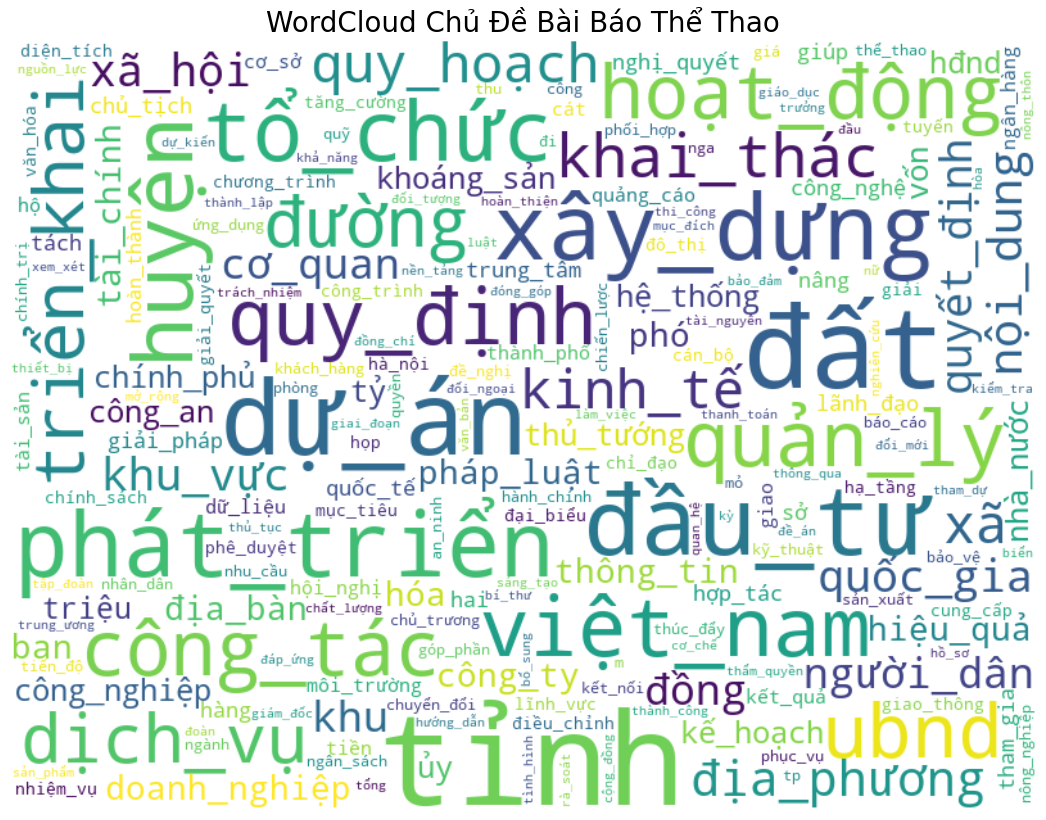

In [107]:
# Tạo WordCloud từ tần suất từ
wordcloud = WordCloud(
    width=800,
    height=600,
    background_color='white',
    # font_path='VnArial.ttf',  # Đảm bảo bạn có font hỗ trợ tiếng Việt
    max_words=200,
    max_font_size=100,
    min_font_size=10,
    collocations=False
).generate_from_frequencies(word_freq)

# Hiển thị WordCloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Chủ Đề Bài Báo Thể Thao', fontsize=20)
plt.show()